# Importation

In [105]:
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d enzodurand/boudingboxonlyhanddataset
# ! unzip boudingboxonlyhanddataset.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
boudingboxonlyhanddataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  boudingboxonlyhanddataset.zip
replace index_label_bbox.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: index_label_bbox.csv    
  inflating: index_label_bbox_validation.csv  
  inflating: output/output/img0.jpg  
  inflating: output/output/img1.jpg  
  inflating: output/output/img10.jpg  
  inflating: output/output/img100.jpg  
  inflating: output/output/img1000.jpg  
  inflating: output/output/img1001.jpg  
  inflating: output/output/img1002.jpg  
  inflating: output/output/img1003.jpg  
  inflating: output/output/img1004.jpg  
  inflating: output/output/img1005.jpg  
  inflating: output/output/img1006.jpg  
  inflating: output/output/img1007.jpg  
  inflating: output/output/img1008.jpg  
  inflating: output/output/img1009.jpg  
  inflating: output/output/img101.jpg  
  inflating: output/output/

In [106]:
import os
import copy
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import time
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score 
from matplotlib import pyplot as plt

import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset

# Kaggle/Colab setup

# Global variables 

In [107]:
INPUT_SIZE = 400
BATCH_SIZE = 64
N_CLASS = 4
COLAB=True

## TPU
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()
# torch.set_default_tensor_type('torch.FloatTensor')

## GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [108]:
if COLAB:
  PATH_LABELS = "/content/index_label_bbox.csv"
  PATH_IMG = "/content/output/output"
  PATH_LABELS_VALID = "/content/index_label_bbox_validation.csv"
  PATH_IMG_VALID = "/content/output_validation/output_validation"
else:
  PATH_LABELS = "../input/boudingboxonlyhanddataset/index_label_bbox.csv"
  PATH_IMG = "../input/boudingboxonlyhanddataset/output/output"
  PATH_LABELS_VALID = "../input/boudingboxonlyhanddataset/index_label_bbox_validation.csv"
  PATH_IMG_VALID = "../input/boudingboxonlyhanddataset/output_validation/output_validation"

# Data functions

In [109]:
class HandGestureDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, os.listdir(self.img_dir)[idx])
        image = read_image(img_path)
        path = str("output/"+os.listdir(self.img_dir)[idx]).split("/")[0]
        line = self.img_labels["index"] == str(path+"/"+os.listdir(self.img_dir)[idx])
        x, y, end_x, end_y = self.img_labels.loc[line]["x"].item(),\
                               self.img_labels.loc[line]["y"].item(),\
                               self.img_labels.loc[line]["x_end"].item(),\
                               self.img_labels.loc[line]["y_end"].item()
        x, y, end_x, end_y = x/INPUT_SIZE, y/INPUT_SIZE, end_x/INPUT_SIZE, end_y/INPUT_SIZE
        if self.transform:
            image = self.transform(image)
#         image = F.normalize(image, dim = 0)
        return {'image':image, 'label':[x,y,end_x,end_y]}

In [110]:
def prepare_data_vgg(data_type):
    ## Parameters fitting vgg/imagenet
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]

    ## pytorch transformer objects
    transformVGGTrain=transforms.Compose([
            transforms.ToPILImage(),
        
            ## can try
            # transforms.ColorJitter(brightness=0.5, hue=0.5),
            # transforms.RandomAdjustSharpness(sharpness_factor=3),
            # transforms.RandomAutocontrast(),
            # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.01, 5)),
        
            ## don't use or it will ruin bounding box labels
#             transforms.RandomRotation(degrees=(-15, 15)),
#             transforms.RandomPerspective(distortion_scale=0.4, p=0.2),
#             transforms.RandomAffine(degrees=(0, 5), translate=(0, 0.18), scale=(0.7, 1)),
        
            ## too much
            # transforms.RandomSolarize(threshold=192.0),
#             transforms.RandomPosterize(bits=2),
#             transforms.RandomInvert(),
#             transforms.RandomEqualize(),
        
            transforms.Resize(size=(INPUT_SIZE, INPUT_SIZE)),
            transforms.ToTensor(),
#             transforms.Normalize(mean, std) ## test with and without
        ])
    transformVGGValid=transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size=(INPUT_SIZE, INPUT_SIZE)),
            transforms.ToTensor(),
#             transforms.Normalize(mean, std) ## test with and without
        ])

    if data_type == "custom":
        ## Custom dataset
        VGG_dataset_train = HandGestureDataset(PATH_LABELS, PATH_IMG, transformVGGTrain)
        VGG_dataset_valid = HandGestureDataset(PATH_LABELS_VALID, PATH_IMG_VALID, transformVGGValid)
        VGG_trainloader = torch.utils.data.DataLoader(VGG_dataset_train, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
        VGG_validloader = torch.utils.data.DataLoader(VGG_dataset_valid, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
    
    return VGG_trainloader, VGG_validloader

# Loading data into pytorch dataset and dataloader objects

In [111]:
VGG_trainloader, VGG_validloader = prepare_data_vgg("custom")

In [112]:
# for img in VGG_trainloader:
#     for i in img["image"][:1]:
#         i = i.permute(1,2,0)
#         plt.imshow(np.array(i))
#         plt.show()

# Model functions

In [113]:
def train(model, epochs, train_loader, valid_loader, learning_rate, patience, feature_extract=False):
    ## Early stopping variables
    es = EarlyStopping(patience=patience)
    terminate_training = False
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    model = model.to(device)
    ## Training only the parameters where we require gradient since we are fine-tuning
    params_to_update = model.parameters()
    print("params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t", name)
                
    ## Setting up our optimizer
    optim = torch.optim.Adam(params_to_update, lr=learning_rate)
    
    ## Setting up our loss function
    loss = nn.MSELoss()
    
    ## Running the train loop
    print(f"running {model.name}")
    for epoch in range(epochs):
        cumloss, count = 0, 0
        model.train()
        for item in train_loader:
            optim.zero_grad()
            x, y = item["image"], item["label"]
            x = item["image"].to(device)
            
            res = []
            for e in y:
                res.append(np.array(e))
            res = np.array(res).T
            y = torch.as_tensor(res)
            y = y.to(torch.float32)
            y = y.to(device)
            
            yhat = model(x)

            l = loss(yhat, y)
            l.backward()
            # xm.optimizer_step(optim, barrier=True)
            optim.step()
            cumloss += l * len(x)
            count += len(x)
        print("epoch :", epoch, end="")
        print(", train_loss: ", cumloss.cpu().item()/count, end="")
        if epoch % 1 == 0:
            model.eval()
            with torch.no_grad():
                valid_cumloss, count = 0, 0
                for x,y in valid_loader:
                    x, y = item["image"], item["label"]
                    x = item["image"].to(device)
                    res = []
                    for e in y:
                        res.append(np.array(e))
                    res = np.array(res).T
                    y = torch.as_tensor(res)
                    y = y.to(torch.float32)
                    y = y.to(device)
                    yhat = model(x)
                    valid_cumloss += loss(yhat,y) * len(x)
                    count += len(x)
                print(", valid_loss: ", valid_cumloss.cpu().item()/count)
                ## Early stopping
                if valid_cumloss/count < best_loss:
                    best_loss = valid_cumloss/count
                    best_model_wts = copy.deepcopy(model.state_dict())
                if es.step(valid_cumloss.cpu().item()/count):
                    terminate_training = True
                    break
        if terminate_training:
            break
    print('Best val loss: {:4f}'.format(best_loss))
    ## Returns the best model
    model.load_state_dict(best_model_wts)
    return model

def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for name,p in model.named_parameters():
            if "features" in name:
                p.requires_grad = False    
            else:
                p.requires_grad = True  

# Loading the model and modifying the classifier part
### Maybe we could try to modify only the last classifier layer ?

In [114]:
## Loading vgg16 model pretrained on imagenet
vgg = models.vgg16(pretrained=True)

vgg.classifier = nn.Sequential(nn.Linear(25088, 4096), 
                               nn.ReLU(), 
                              #  nn.Dropout(0.5),        
                               nn.Linear(4096, 1024), 
                               nn.ReLU(), 
#                                nn.Dropout(0.5),        
                               nn.Linear(1024, 256),
                               nn.ReLU(), 
#                                nn.Dropout(0.5),        
                               nn.Linear(256, N_CLASS),
                               nn.Sigmoid())

print(vgg.eval())

## Sets all the requires grad of the classifier layers to True
set_parameter_requires_grad(vgg, True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Implementing early stopping

In [115]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)
        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False
        if np.isnan(metrics):
            return True
        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1
        if self.num_bad_epochs >= self.patience:
            return True
        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

# Training only the modified parts of the classifier

In [116]:
print(len(VGG_trainloader))
print(len(VGG_validloader))

## Fine-tuning the model on our data
vgg.name = "VGG"

best_model = train(model=vgg, 
                   epochs=500, 
                   train_loader=VGG_trainloader, 
                   valid_loader=VGG_validloader, 
                   learning_rate=3e-4, ## learning rate for Adam optimizer
                   patience=15) ## metric for earlystopping : val_loss 

26
7
params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.2.weight
	 classifier.2.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias
running VGG
epoch : 0, train_loss:  0.03951289352861423, valid_loss:  0.027289816311427524
epoch : 1, train_loss:  0.015328539227976383, valid_loss:  0.008055482591901506
epoch : 2, train_loss:  0.007986863839973523, valid_loss:  0.008935774366060892
epoch : 3, train_loss:  0.004765651469091767, valid_loss:  0.0035183500675928024
epoch : 4, train_loss:  0.004032266082115544, valid_loss:  0.002715816277833212
epoch : 5, train_loss:  0.0027359784806816325, valid_loss:  0.0018027956996645247
epoch : 6, train_loss:  0.001945040758373668, valid_loss:  0.0016390663527307055
epoch : 7, train_loss:  0.001429025843305495, valid_loss:  0.001080943981096858
epoch : 8, train_loss:  0.0011326189614036708, valid_loss:  0.0009229461706819988
epoch : 9, train_loss:  0.0008918563428434353, valid_loss:  0.00078652737

# Checking predictions

In [117]:
def draw_predictions(image, preds):
    startX, startY, endX, endY = preds
    # scale the predicted bounding box coordinates based on the image
    # dimensions    
    startX = int(startX * INPUT_SIZE)
    startY = int(startY * INPUT_SIZE)
    endX = int(endX * INPUT_SIZE)
    endY = int(endY * INPUT_SIZE)
#     print(startX, startY, endX, endY)
    # draw the predicted bounding box on the image
    image = image.numpy().copy()
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    # show the output image
    plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


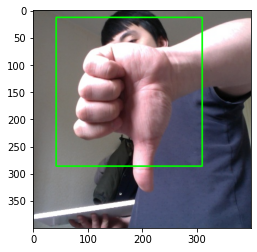

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


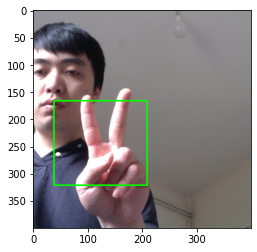

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


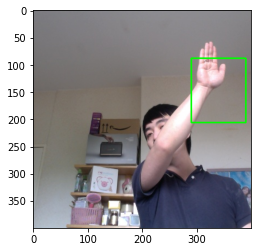

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


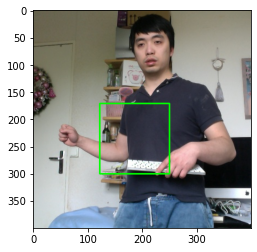

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


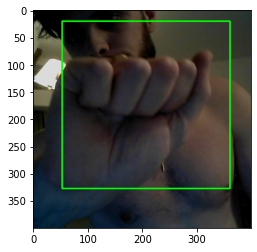

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


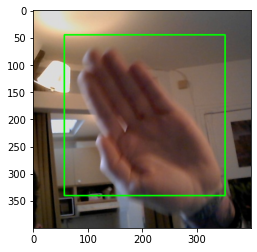

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


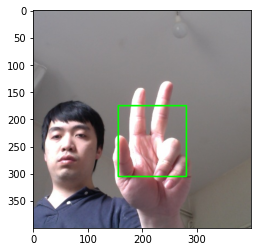

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


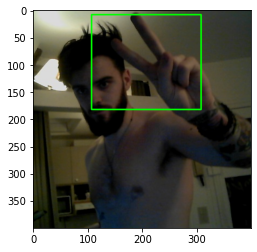

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


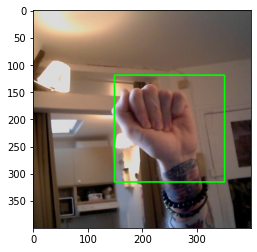

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


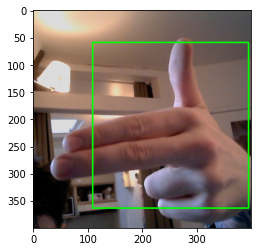

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


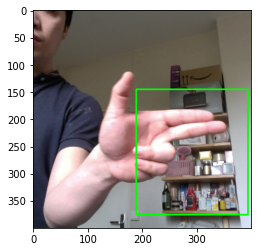

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


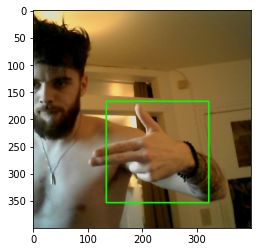

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


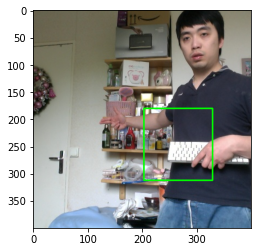

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


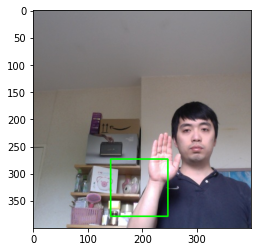

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


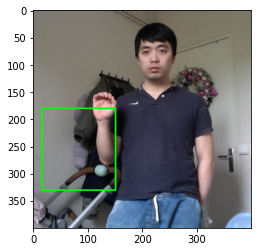

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


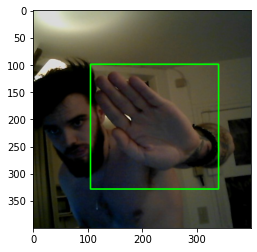

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


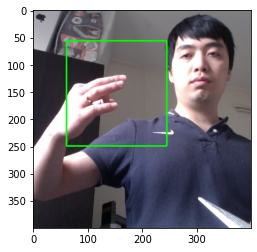

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


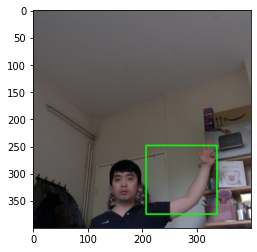

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


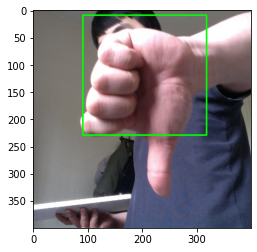

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


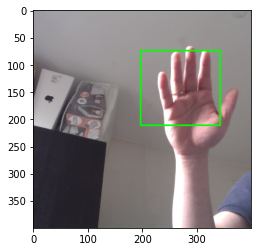

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


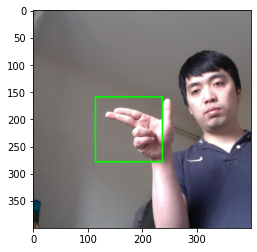

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


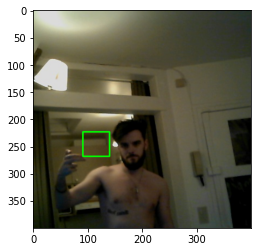

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


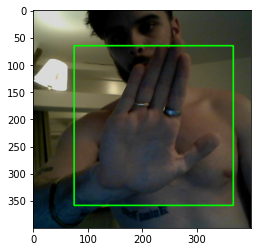

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


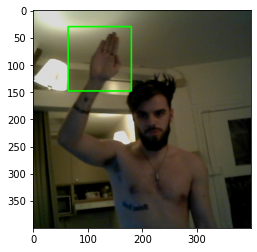

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


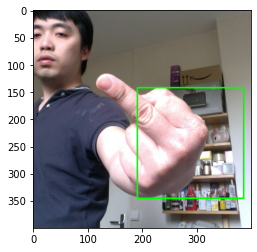

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


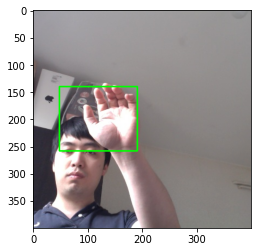

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


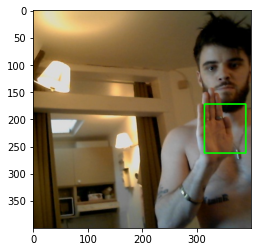

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


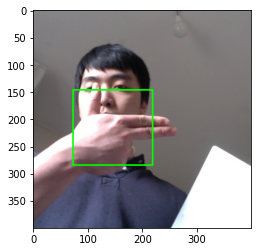

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


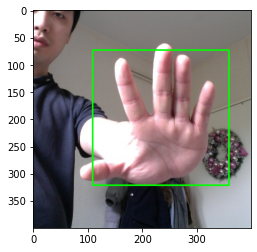

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


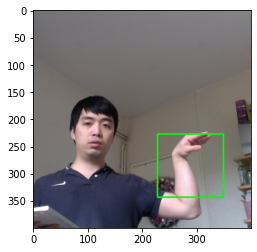

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


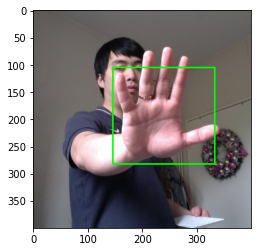

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


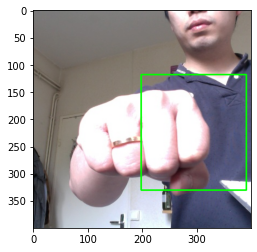

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


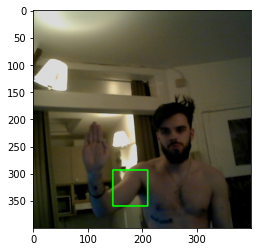

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


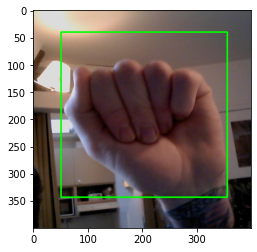

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


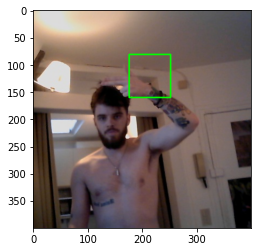

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


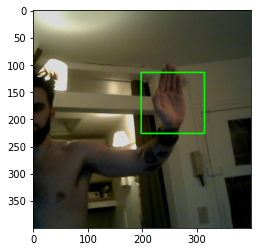

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


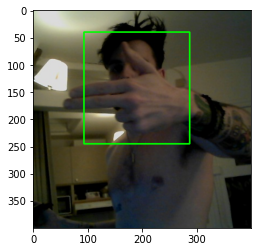

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


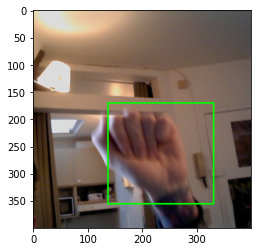

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


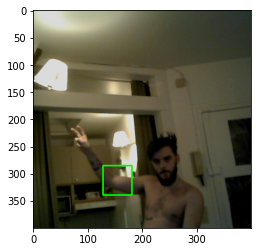

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


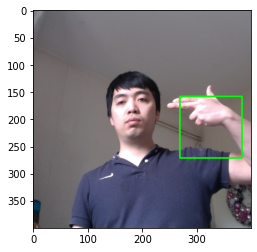

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


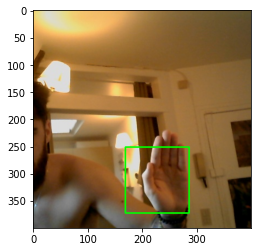

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


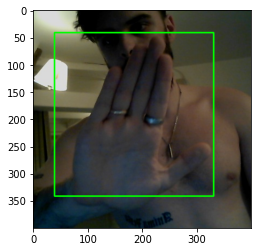

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


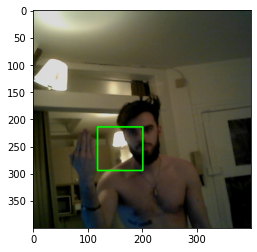

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


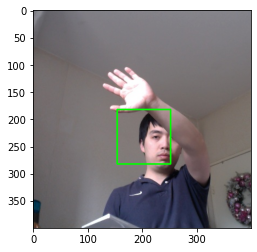

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


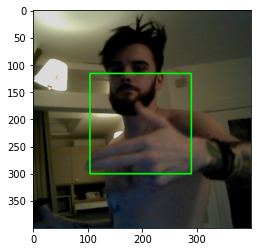

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


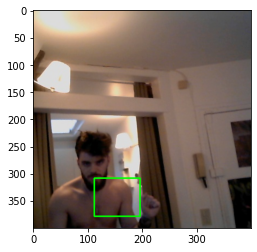

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


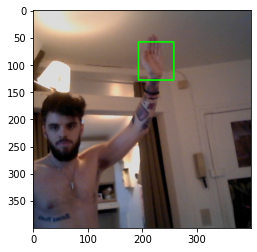

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


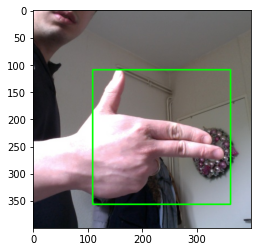

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


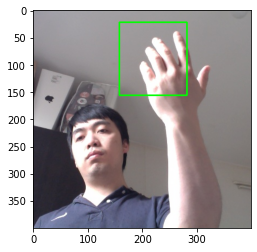

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


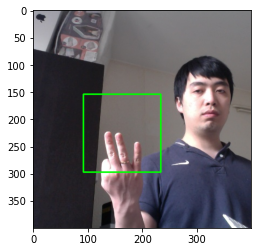

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


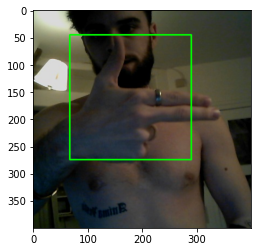

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


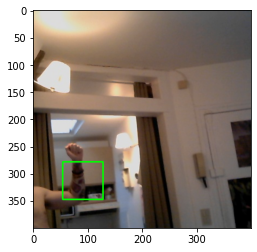

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


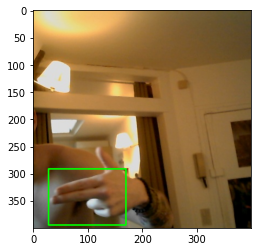

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


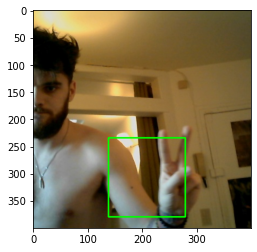

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


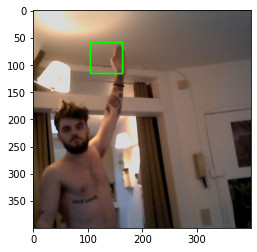

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


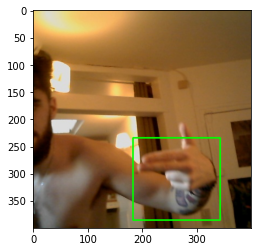

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


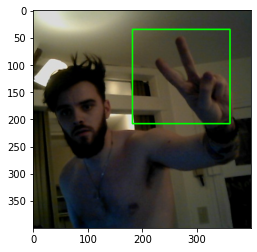

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


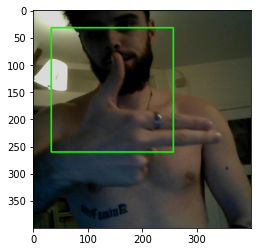

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


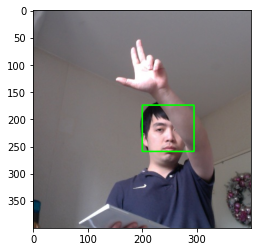

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


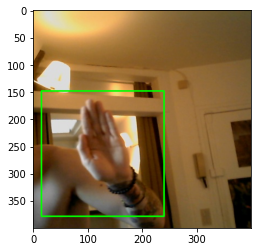

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


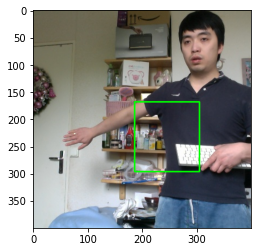

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


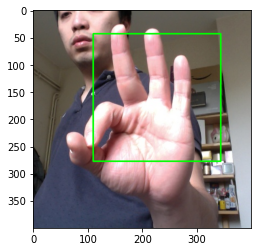

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


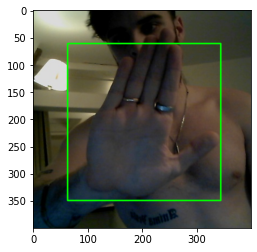

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


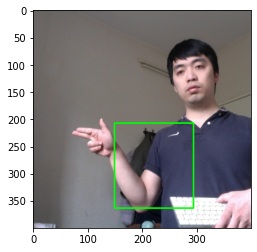

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


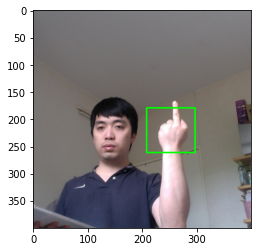

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


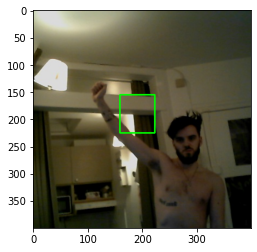

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


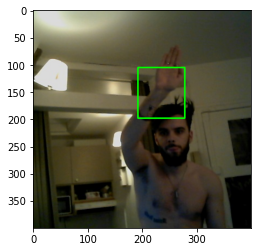

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


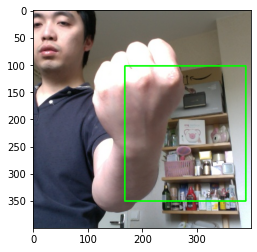

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


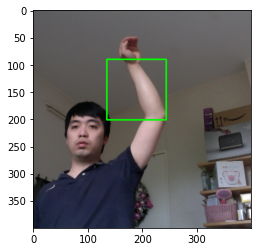

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


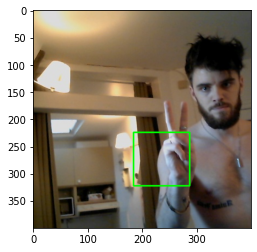

In [118]:
with torch.no_grad():
    for item in VGG_validloader:
        x, y = item["image"], item["label"]
        base_img = item["image"]
        x = item["image"].to(device)
        res = []
        for e in y:
            res.append(np.array(e))
        res = np.array(res).T
        y = torch.as_tensor(res)
        y = y.to(torch.float32)
        y = y.to(device)
        yhat = best_model(x)
        for i in range(10):
            draw_predictions(base_img[i].permute(1,2,0), yhat.cpu()[i])

# Saving the model in .pth and .onnx extension

In [122]:
PATH = "./"
torch.save(best_model.state_dict(), os.path.join(PATH,"boundingbox_vgg_last.pth"))
from google.colab import files
files.download(os.path.join(PATH,"boundingbox_vgg_last.pth"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [120]:
# del vgg
# del best_model

In [121]:
# model = models.vgg16(pretrained=True)
# model.classifier[0] = nn.Linear(25088, 8192)
# model.classifier[3] = nn.Linear(8192, 1024)
# model.classifier[6] = nn.Linear(1024, N_CLASS)
# model.load_state_dict(torch.load(os.path.join(PATH,"vgg.pth"), map_location='cpu'))
# model.eval() 

# dummy_input = torch.randn(BATCH_SIZE, 3, INPUT_SIZE, INPUT_SIZE)  
# torch.onnx.export(model,   
#                   dummy_input, 
#                   "vgg.onnx",
#                   export_params=True,
#                   do_constant_folding=True, 
#                   input_names = ['modelInput'],
#                   output_names = ['modelOutput'])